In [5]:
!pip install monai scipy matplotlib torch torchvision Pillow tqdm h5py


Epoch 1/5: 100%|██████████| 50/50 [00:21<00:00,  2.38it/s]


Epoch 1/5, Loss: 28.7231


Epoch 2/5: 100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


Epoch 2/5, Loss: 27.1559


Epoch 3/5: 100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


Epoch 3/5, Loss: 25.5619


Epoch 4/5: 100%|██████████| 50/50 [00:20<00:00,  2.38it/s]


Epoch 4/5, Loss: 24.3818


Epoch 5/5: 100%|██████████| 50/50 [00:20<00:00,  2.41it/s]


Epoch 5/5, Loss: 23.4740


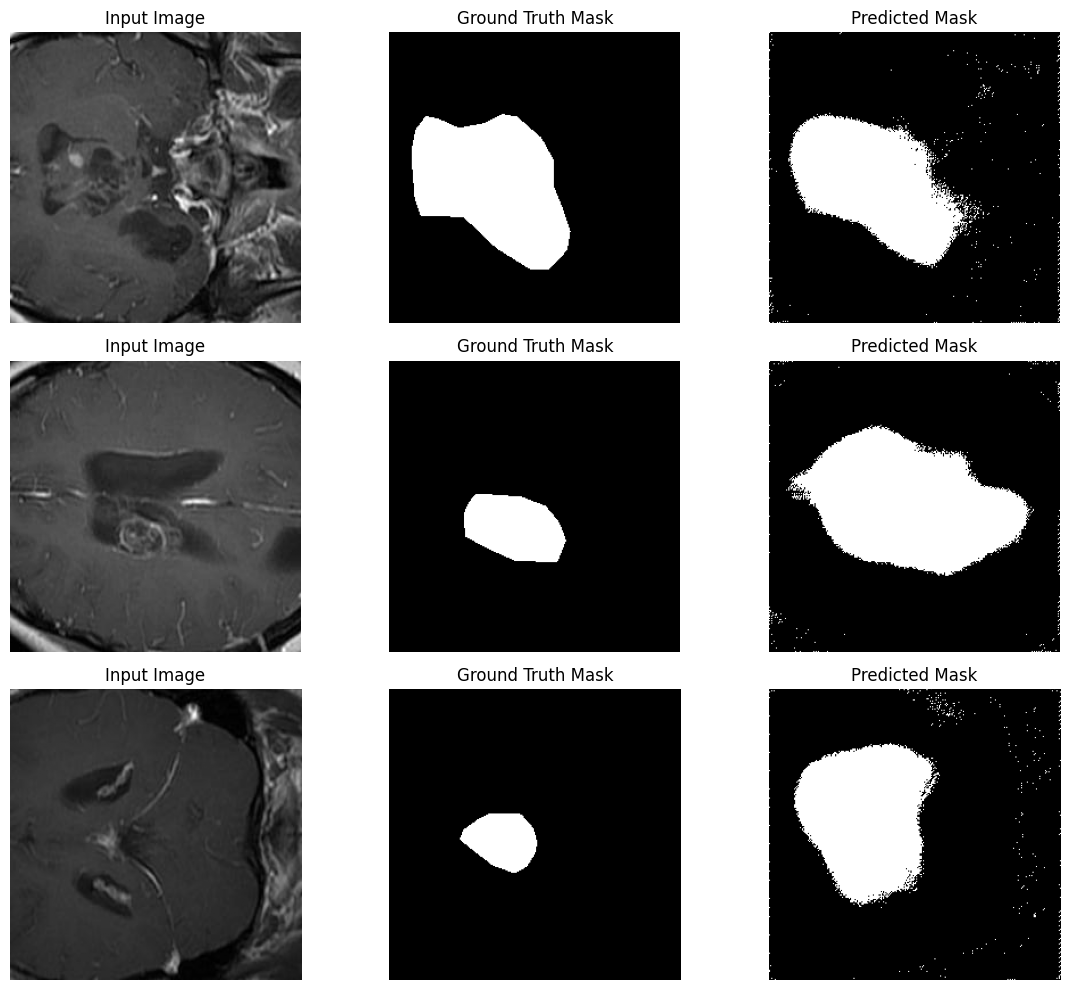

In [ ]:
# ─── Full Brain Tumor Segmentation Project with .mat → .jpg Conversion ───


import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from tqdm import tqdm
from random import SystemRandom

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged,
    ToTensord, EnsureTyped, ResizeWithPadOrCropd, AsDiscreted
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.utils import set_determinism

# ─── Reproducibility for training ────────────────────────────────────────────
set_determinism(seed=0)

# ─── Quick‐test vs Full dataset switch ───────────────────────────────────────
# Set MAX_SAMPLES = 200 for a fast 200-sample run, or None for all files

#importantttttt

#for a quicker check run time, uncomment this line
MAX_SAMPLES = 200

#for full 766 data set, uncomment this line and comment the one above
# MAX_SAMPLES = None

# ─── Step 1: Convert .mat (v7.3) → .jpg images and .png masks ───────────────
MAT_INPUT_FOLDER = "./brain_tumor_mat/git_brainTumorDataPublic_2299-3064"
OUTPUT_FOLDER    = "./brain_tumor_dataset"
LABEL_FOLDER     = os.path.join(OUTPUT_FOLDER, "labels")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(LABEL_FOLDER,   exist_ok=True)

# build the list of .mat files, sliced by MAX_SAMPLES if set
all_files = sorted(f for f in os.listdir(MAT_INPUT_FOLDER) if f.endswith(".mat"))
mat_files = all_files[:MAX_SAMPLES] if MAX_SAMPLES is not None else all_files

train_files = []
for fname in mat_files:
    path = os.path.join(MAT_INPUT_FOLDER, fname)
    with h5py.File(path, 'r') as f:
        image = np.array(f['cjdata']['image']).T
        mask  = np.array(f['cjdata']['tumorMask']).T
        label = int(np.array(f['cjdata']['label']).squeeze())

    # Normalize image to [0,255] and binarize mask
    im   = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
    mbin = (mask > 0).astype(np.uint8)

    # Save into class-specific folder
    cls_dir = os.path.join(OUTPUT_FOLDER, str(label))
    os.makedirs(cls_dir, exist_ok=True)
    base    = os.path.splitext(fname)[0]
    ipath   = os.path.join(cls_dir,      base + ".jpg")
    mpath   = os.path.join(LABEL_FOLDER, base + "_label.png")

    Image.fromarray(im).save(ipath)
    Image.fromarray((mbin * 255).astype(np.uint8)).save(mpath)

    train_files.append({"image": ipath, "label": mpath})

# ─── Step 2: Define transforms ────────────────────────────────────────────────
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ResizeWithPadOrCropd(keys=["image", "label"], spatial_size=[256, 256]),
    ScaleIntensityRanged(keys=["image"], a_min=0, a_max=255, b_min=0.0, b_max=1.0, clip=True),
    AsDiscreted(keys=["label"], threshold=0.5),
    ToTensord(keys=["image", "label"])
])

# ─── Step 3: Create DataLoader (non-caching for speed) ───────────────────────
train_ds     = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=4, num_workers=2, pin_memory=True)

# ─── Step 4: Define UNet, Loss, Optimizer ───────────────────────────────────
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model         = UNet(
    spatial_dims=2, in_channels=1, out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2), num_res_units=2
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer     = torch.optim.Adam(model.parameters(), lr=1e-4)

# ─── Step 5: Training loop ───────────────────────────────────────────────────
max_epochs = 5
model.train()
for epoch in range(1, max_epochs + 1):
    epoch_loss = 0
    for batch_data in tqdm(train_loader, desc=f"Epoch {epoch}/{max_epochs}"):
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch}/{max_epochs}, Loss: {epoch_loss:.4f}")

# ─── Step 6: Save model ──────────────────────────────────────────────────────
torch.save(model.state_dict(), "unet_brain_tumor_segmentation.pth")

# ─── Step 7: Visualize 3 truly random predictions ─────────────────────────────
sysrand = SystemRandom()
model.eval()
with torch.no_grad():
    samples = sysrand.sample(train_files, 3)
    fig, axes = plt.subplots(3, 3, figsize=(12, 10))
    for i, sample in enumerate(samples):
        data  = train_transforms(sample)
        img   = data["image"].unsqueeze(0).to(device)
        lbl   = data["label"].unsqueeze(0).to(device)
        out   = model(img)
        pred  = torch.argmax(out, dim=1)[0].cpu().numpy()
        inp   = img[0, 0].cpu().numpy()
        gt    = lbl[0, 0].cpu().numpy()

        axes[i][0].imshow(inp, cmap="gray")
        axes[i][0].set_title("Input Image")
        axes[i][1].imshow(gt,  cmap="gray")
        axes[i][1].set_title("Ground Truth Mask")
        axes[i][2].imshow(pred, cmap="gray")
        axes[i][2].set_title("Predicted Mask")
        for a in axes[i]:
            a.axis("off")

    plt.tight_layout()
    plt.show()


